In [68]:
## bigram with statistical modeling.

# Loading the data set
words = open("./names.txt", "r").read().splitlines()
words[:3]

['أبي', 'أحمد', 'أحنف']

In [69]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s, i in stoi.items()}
len_chars = len(itos)

In [70]:
# Making a lookup of distributed probability
import torch

N = torch.zeros((len_chars, len_chars), dtype=torch.int32)
for word in words:
    chs = ["."] + list(word) + ["."] 
    for ch1, ch2 in zip(chs, chs[1:]):
        stoi1 = stoi[ch1]
        stoi2 = stoi[ch2]
        N[stoi1][stoi2] += 1

In [71]:
# TODO: remove
N[0]

tensor([ 0,  0,  0,  1, 16,  0,  5,  0,  4, 28,  0,  5,  2, 14, 29,  7,  2,  0,
        10,  4,  9,  3,  4,  2,  3,  0, 16,  3,  5,  5,  3,  3, 20,  8,  6,  4,
         0,  2], dtype=torch.int32)

In [72]:
# TODO: remove
p = N[0].float()
p = p / p.sum()
p

tensor([0.0000, 0.0000, 0.0000, 0.0045, 0.0717, 0.0000, 0.0224, 0.0000, 0.0179,
        0.1256, 0.0000, 0.0224, 0.0090, 0.0628, 0.1300, 0.0314, 0.0090, 0.0000,
        0.0448, 0.0179, 0.0404, 0.0135, 0.0179, 0.0090, 0.0135, 0.0000, 0.0717,
        0.0135, 0.0224, 0.0224, 0.0135, 0.0135, 0.0897, 0.0359, 0.0269, 0.0179,
        0.0000, 0.0090])

In [73]:
# TODO: remove

g = torch.Generator().manual_seed(2147483647)
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()

ix

32

(np.float64(-0.5), np.float64(37.5), np.float64(37.5), np.float64(-0.5))

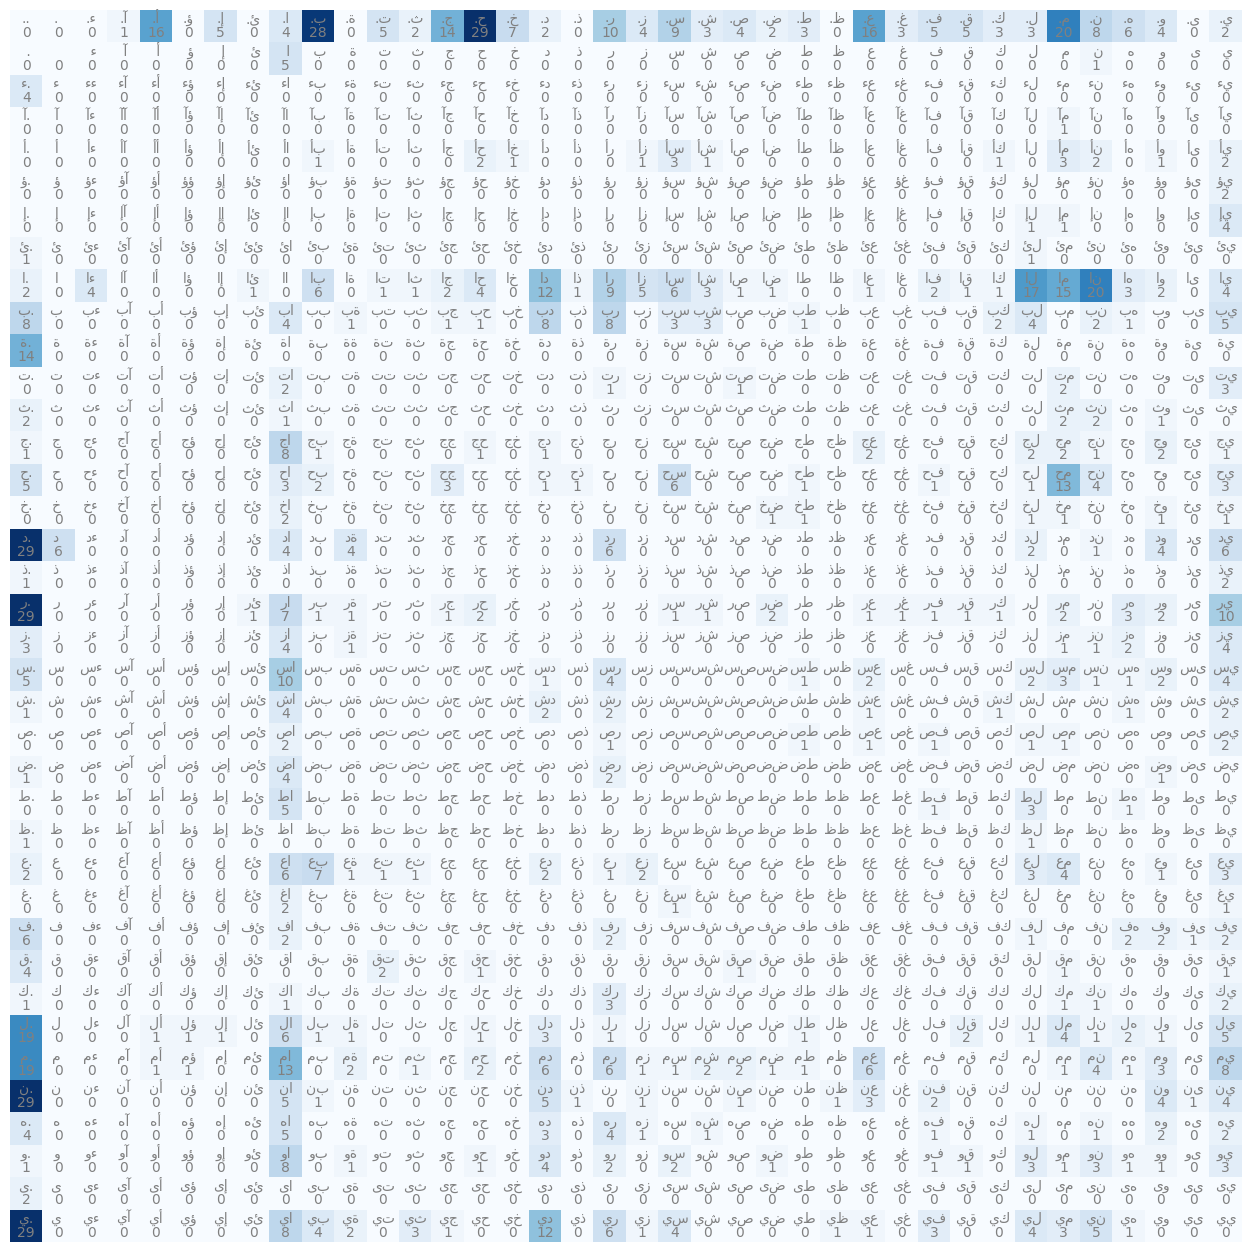

In [74]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(N.numpy(), cmap='Blues')
for i in range(len_chars):
    for j in range(len_chars):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off')

In [75]:
g = torch.Generator().manual_seed(2147483647)

for i in range(10):
    outs = []
    ix = 0
    P = N.float() / N.sum(dim=1, keepdim=True)
    while True:
        # p = N[ix].float()
        # p = p / p.sum()
        ix = torch.multinomial(P[ix], num_samples=1, replacement=True, generator=g).item() # add generator
        outs.append(itos[ix])
        # # print(f"{ix=}, {itos[ix]=}")
        # print(itos[ix])   
        if ix == 0:
            break
    print(''.join(outs)) 

مال.
عبلد.
سي.
قحمؤير.
إماشاسارفولؤي.
خضانود امد.
ب.
ن.
شد.
ب.


In [76]:
# computing loss for the bigram model

# likelihood = product of probabilities
#log_likelihood = log(pA) + log(pB) + log(pC) + ...

log_likelihood = 0
n = 0

for word in words[:1]:
    chs = ["."] + list(word) + ["."] 
    for ch1, ch2 in zip(chs, chs[1:]):
        stoi1 = stoi[ch1]
        stoi2 = stoi[ch2]

        prob = P[stoi1][stoi2]

        log_prob = torch.log(prob)
        log_likelihood += log_prob

        n += 1

        print(f"{ch1=}, {ch2=}, prob={prob:.4f}, log_prob={log_prob:.4f}")

print(f"log_likelihood={log_likelihood:.4f}")
nll = -log_likelihood
print(f"nll={nll:.4f}")
print(f"n={n}")
print(f"nll/n={nll/n:.4f}")

# P

ch1='.', ch2='أ', prob=0.0717, log_prob=-2.6346
ch1='أ', ch2='ب', prob=0.0556, log_prob=-2.8904
ch1='ب', ch2='ي', prob=0.0962, log_prob=-2.3418
ch1='ي', ch2='.', prob=0.3295, log_prob=-1.1100
log_likelihood=-8.9768
nll=8.9768
n=4
nll/n=2.2442


In [77]:
# method 2, using neural nets to compute the bigrams probability


# create dataset
xs = []
ys = []

for w in words:
    chs = ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chs, chs[1:]):
        xs.append(stoi[ch1])
        ys.append(stoi[ch2])

print(xs)
print(ys)
xs = torch.tensor(xs)
ys = torch.tensor(ys)

g = torch.Generator().manual_seed(2147483647)
W = torch.randn(len_chars, len_chars, generator=g, requires_grad=True)


[0, 4, 9, 37, 0, 4, 14, 32, 16, 0, 4, 14, 33, 28, 0, 4, 19, 34, 18, 0, 4, 20, 8, 32, 10, 0, 4, 20, 16, 0, 4, 20, 32, 18, 0, 4, 21, 18, 28, 0, 4, 30, 18, 32, 0, 8, 31, 4, 15, 23, 18, 0, 8, 31, 32, 12, 33, 36, 0, 8, 31, 33, 26, 32, 8, 33, 0, 8, 31, 35, 31, 37, 16, 0, 6, 32, 8, 32, 0, 3, 32, 18, 0, 4, 32, 37, 10, 0, 4, 32, 37, 33, 0, 4, 33, 22, 8, 18, 37, 0, 4, 33, 35, 18, 0, 4, 35, 20, 0, 6, 37, 8, 16, 0, 6, 37, 12, 8, 18, 0, 4, 37, 20, 18, 0, 4, 37, 32, 33, 0, 6, 37, 33, 8, 20, 0, 6, 37, 34, 8, 9, 0, 9, 8, 16, 37, 0, 9, 8, 20, 31, 0, 9, 8, 21, 18, 0, 9, 8, 34, 18, 0, 9, 13, 8, 16, 0, 9, 16, 18, 0, 9, 16, 18, 37, 0, 9, 16, 35, 37, 0, 9, 18, 8, 2, 0, 9, 18, 8, 29, 0, 9, 18, 8, 30, 0, 9, 18, 26, 32, 0, 9, 18, 34, 8, 33, 0, 9, 18, 34, 35, 32, 0, 9, 18, 7, 0, 9, 20, 8, 32, 0, 9, 20, 24, 8, 32, 0, 9, 20, 37, 32, 0, 9, 21, 8, 32, 10, 0, 9, 21, 37, 18, 0, 9, 24, 31, 0, 9, 30, 18, 0, 9, 30, 18, 37, 0, 9, 31, 8, 31, 0, 9, 31, 9, 31, 0, 9, 33, 16, 8, 18, 37, 0, 9, 33, 16, 18, 0, 9, 34, 8, 2, 0, 11

In [78]:
import torch.nn.functional as F


for i in range(200):
    # forward pass
    xenc = F.one_hot(xs, num_classes=len_chars).float()
    logits = xenc @ W
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdim=True)
    loss = -probs[torch.arange(len(ys)), ys].log().mean()
    print(f"loss={loss:.4f}")

    # backward pass
    W.grad = None
    loss.backward()


    # update
    W.data += -50 * W.grad




loss=4.1629
loss=3.7461
loss=3.4717
loss=3.2766
loss=3.1460
loss=3.0570
loss=2.9886
loss=2.9316
loss=2.8828
loss=2.8406
loss=2.8039
loss=2.7717
loss=2.7435
loss=2.7185
loss=2.6962
loss=2.6761
loss=2.6579
loss=2.6413
loss=2.6261
loss=2.6121
loss=2.5991
loss=2.5870
loss=2.5758
loss=2.5654
loss=2.5556
loss=2.5464
loss=2.5379
loss=2.5298
loss=2.5222
loss=2.5150
loss=2.5083
loss=2.5019
loss=2.4959
loss=2.4902
loss=2.4848
loss=2.4797
loss=2.4748
loss=2.4701
loss=2.4657
loss=2.4615
loss=2.4575
loss=2.4536
loss=2.4500
loss=2.4464
loss=2.4431
loss=2.4398
loss=2.4367
loss=2.4338
loss=2.4309
loss=2.4281
loss=2.4255
loss=2.4229
loss=2.4205
loss=2.4181
loss=2.4158
loss=2.4136
loss=2.4114
loss=2.4094
loss=2.4073
loss=2.4054
loss=2.4035
loss=2.4017
loss=2.3999
loss=2.3982
loss=2.3965
loss=2.3949
loss=2.3933
loss=2.3918
loss=2.3903
loss=2.3889
loss=2.3875
loss=2.3861
loss=2.3848
loss=2.3835
loss=2.3822
loss=2.3810
loss=2.3798
loss=2.3786
loss=2.3775
loss=2.3764
loss=2.3753
loss=2.3742
loss=2.3732
loss

In [80]:
# Sampling from the neural net
g = torch.Generator().manual_seed(2147483647)

for i in range(30):

    out = []
    ix = 0

    while True:

        xenc = F.one_hot(torch.tensor([ix]), num_classes=len_chars).float()
        logits = xenc @ W
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdim=True)
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])

        if ix == 0:
            break

    print("".join(out))

مال.
عبلد.
سي.
قحمؤير.
إماشاسارفولؤي.
خضانود امد.
ب.
ن.
شد.
ب.
ريد.
ساكي.
أزه.
بد.
له.
ق.
ريزالطادنوامأيمان.
بسا.
فاحادازيد.
أشيد احجليدادراناني.
تيماس.
حد.
زال.
بسادة.
ف.
ميد.
بة.
بيهد.
م.
سل.
